# Import requirements

In [1]:
from __future__ import division
import glob
import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
import time
from scipy import stats
from scipy import interp
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from functools import partial
from scipy.integrate import quad
%matplotlib inline

In [2]:
from sklearn.lda import LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import cross_validation as cv
from sklearn import metrics

# Functions

In [185]:
def import_data(filepath):
    DF = pd.read_csv(filepath)
    C = ['Patient','Visit','DateOfVisit','Age','Gender','ART','VL','iVL','pVL',
     'CD4','iCD4','nCD4','CD8','iCD8','nCD8','TMHDS','VisitDate','GDS','Prot', 
     'AAPos','Coverage','A','R','N','D','C','Q','E','G','H','I','L','K','M',
     'F','P','S','T','W','Y','V']
    DF = DF[C]
    return DF

def slice_position(df, pos):
    m = df['AAPos'] == pos
    sliced_df = df[m]
    return sliced_df

def reformat_section(df):
    '''Must be a dataframe containing only 1 position'''
    pos = str(int(list(df.AAPos)[0]))
    AAs = ['A','R','N','D','C','Q','E','G','H','I',
           'L','K','M','F','P','S','T','W','Y','V']
    newnames_dict = {}
    for item in AAs:
        newnames_dict[item]= pos+item
    df_renamed = df.rename(columns = newnames_dict)
    df_renamed.drop(['AAPos','Coverage', 'Prot', 'DateOfVisit', 'VisitDate'], axis=1, inplace=True)
    return df_renamed
    
def reformat_dataframe(DF, tat_length):
    on_columns = ['Patient', 'Visit', 'Age', 'Gender', 'ART', 'VL','iVL', 'pVL', 'CD4', 'iCD4', 
                  'nCD4', 'CD8', 'iCD8', 'nCD8', 'TMHDS', 'GDS']
    start_df = slice_position(DF, 1)
    sklearn_df = reformat_section(start_df)
    for i in range(2,tat_length+1):
        pos_df = slice_position(DF, i)
        pos_df2 = reformat_section(pos_df)
        sklearn_df = pd.merge(sklearn_df, pos_df2,
                   left_on=on_columns,
                   right_on=on_columns,
                   how='outer')    
    return sklearn_df

def get_GDS_threshold(sklearn_df):
    sklearn_df['GDS_Threshold'] = sklearn_df['GDS'] > 0.5
    sklearn_df['GDS_Threshold'] = sklearn_df['GDS_Threshold'].astype(int)
    return sklearn_df


### DIVERSITY FILTERING RELATED FUNCTIONS ########################

def import_diversity_data(filepath):
    AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    div_DF = pd.read_csv(filepath)
    div_positions = [int(a) for a in Counter(div_DF.AAPos)]
    return div_positions

def diversityColumnConverter(div_positions):
    AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    keep_positions = []
    for i in div_positions:
        for aa in AAs:
            keep_positions.append(str(i)+(aa))
    return keep_positions

### PLOTTING FUNCTIONS ###########################################

def lda_plot(x1, x2, xlim, savepath):
    mpl.rc('font',family='Arial')
    kde1 = stats.gaussian_kde(x1)
    kde2 = stats.gaussian_kde(x2)
    fig, ax = plt.subplots(figsize=(7,4))
    
    x1_median = np.median(x1)
    x2_median = np.median(x2)
    globmin = min([min(x1),min(x2)])
    globmax = max([max(x1),max(x2)])   
    x_eval = np.linspace(globmin-2, globmax+2, num=200)
    ax.axvline(x1_median, color='firebrick', linestyle='--')
    ax.axvline(x2_median, color='steelblue', linestyle='--')
    
    ax.scatter(x1, np.zeros(x1.shape), color='firebrick',marker='|', s=200)
    ax.scatter(x2, np.zeros(x2.shape), color='steelblue',marker='|', s=200)
    ax.plot(x_eval, kde1(x_eval), color='firebrick', ls = '-')
    ax.plot(x_eval, kde2(x_eval), color='steelblue', ls = '-')
    ax.fill_between(x_eval, kde1(x_eval), color='firebrick', alpha = 0.1)
    ax.fill_between(x_eval, kde2(x_eval), color='steelblue', alpha = 0.1)
    ax.set_xlim(xlim)
    ax.set_ylim([0,0.9])

    ax.set_ylabel('Probability density',size=18, labelpad=10, weight='bold')
    ax.set_xlabel('Linear Discriminant',size=18, labelpad=10, weight='bold')
    ax.tick_params(axis='both',labelsize=14)

    ax.legend([mpl.patches.Patch(color='firebrick',alpha=0.1),
               mpl.patches.Patch(color='steelblue',alpha=0.1)],
               ['Impaired', 'Non-impaired'],
               loc=1, ncol=1, fancybox=False, frameon=False,
               fontsize=10)

    plt.tight_layout()
    plt.show()
    fig.savefig(savepath,
                format='png', dpi=300, bbox_inches='tight')

# SCRIPT Dataframe Prep

In [4]:
DF = import_data('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_abundance.csv') # import
sklearn_df = reformat_dataframe(DF, 101) # reformat
sklearn_df.fillna(sklearn_df.mean(), inplace=True) #fillna
sklearn_df = get_GDS_threshold(sklearn_df) # convert GDS to a threshold

# Diversity filter
div_positions = import_diversity_data('/Users/greg/Desktop/FullNeuroIllumina/Diversity/filterDF.csv')
div_columns = diversityColumnConverter(div_positions)
sklearn_filter_df = sklearn_df[['GDS_Threshold']+div_columns]

In [5]:
print sklearn_filter_df.shape
sklearn_filter_df.head()

(72, 1041)


,GDS_Threshold,1A,1R,1N,1D,1C,1Q,1E,1G,1H,...,101L,101K,101M,101F,101P,101S,101T,101W,101Y,101V
0,1,0.000051,0.002157,0.000051,0.000077,0.002080,0.000051,0.000308,0.001361,0,...,0.000407,0.000000,0,0,0.000081,0.000244,0.000000,0.000163,0,0.00122
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000757,0,0,0.000000,0.004542,0.000000,0.000000,0,0.00000
2,0,0.000000,0.001661,0.000000,0.000000,0.000000,0.000000,0.001661,0.000000,0,...,0.002552,0.000000,0,0,0.000150,0.001201,0.000000,0.000000,0,0.00000
3,0,0.000000,0.001347,0.000673,0.000000,0.000673,0.000000,0.000000,0.002694,0,...,0.000000,0.000000,0,0,0.989574,0.000000,0.001813,0.000000,0,0.00000
4,1,0.000000,0.002994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.003805,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0,0.00000


# Functions

In [6]:
def sklearn_prep(df):   
    on_columns = ['Patient', 'Visit', 'Age', 'Gender', 'ART', 'VL','iVL', 'pVL',
                  'CD4','iCD4', 'nCD4', 'CD8', 'iCD8', 'nCD8', 'TMHDS', 'GDS']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = on_columns + ['GDS_Threshold']
    X = df.drop(drop_cols, axis=1)
    return X, y
    
def sklearn_prep_filter(df):   
    y = np.ravel(df['GDS_Threshold'])
    X = df.drop(['GDS_Threshold'], axis=1)
    return X, y

def bhatta(x1, x2, nbins):    
    global_min = min([min(x1), min(x2)])
    global_max = max([max(x1), max(x2)])
    h1, b1 = np.histogram(x1, bins=nbins, range=(global_min, global_max))
    h2, b2 = np.histogram(x2, bins=nbins, range=(global_min, global_max))    
    h1_ = h1/sum(h1)
    h2_ = h2/sum(h2)
    coeff = 0;
    for i in range(len(h1_)):
        coeff += math.sqrt(h1_[i]*h2_[i])
    bhatta_distance = -np.log(coeff)
    hellinger_distance = math.sqrt(1 - coeff)
    return coeff, bhatta_distance, hellinger_distance

def bhatta_full(x1, x2):
    kde1 = stats.gaussian_kde(x1)
    kde2 = stats.gaussian_kde(x2)
    obj_fun = partial(dy_func, kde1, kde2)
    coeff = quad(obj_fun, -np.inf, np.inf)[0]
    hellinger_distance = math.sqrt(1 - coeff)
    return coeff, hellinger_distance
    
def dy_func(kde1, kde2, x):
    return np.sqrt(kde1(x)*kde2(x))

# Linear Discriminant Analysis

(72, 1040)
1040
0.66


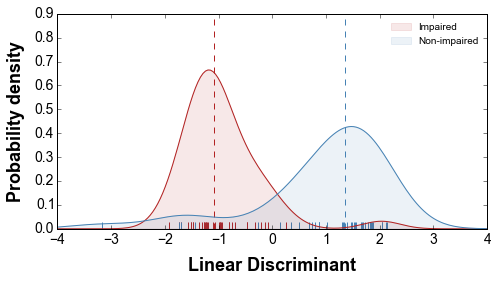

In [186]:
Xdf,y = sklearn_prep_filter(sklearn_filter_df)
X = Xdf.as_matrix()
#selector = VarianceThreshold()
#X = selector.fit_transform(X)

# LDA dimensional reduction
model = LDA(n_components=2, shrinkage=None)
X_transform = model.fit(X, y).transform(X)
print Xdf.shape
print len(model.coef_[0])
coeffs = model.coef_[0]
x1 = X_transform[y == 0, 0]
x2 = X_transform[y == 1, 0]

coeff, bhatta_dist, hellinger_dist = bhatta(x1,x2,10)
c,h = bhatta_full(x1,x2)
#print round(hellinger_dist,2)
print round(h,2)

# plot
lda_plot(x1,x2,[-4,4],'/Users/greg/Desktop/TatFigureStuff/lineardiscriminant.png')

# Linear Discrminant Analysis - Coefficients

In [104]:
def strListReplace(string):
    replace_string = 'ARNDCQEGHILKMFPSTWYV'
    for ch in replace_string:
        if ch in string:
            string = string.replace(ch,'')
    return int(string)

divtable_df = pd.read_csv('/Users/greg/Desktop/FullNeuroIllumina/Diversity/DivTable.csv')
Vdiv = []
AAs = 'ARNDCQEGHILKMFPSTWYV'
for i, row in divtable_df.iterrows():
    V = [i for i in row.Variants if i in AAs]
    p = row.Position
    for v in V:
        Vdiv.append(str(p)+v)

In [105]:
lda_dict = {'Feature':list(Xdf.columns), 'Coefficient':coeffs}
lda_df = pd.DataFrame(lda_dict)
lda_df['Position'] = lda_df['Feature'].apply(strListReplace)
Vmask = lda_df['Feature'].apply(lambda x: x in Vdiv)
lda_df = lda_df[Vmask]
print lda_df.shape
lda_df.sort_values(by='Coefficient', inplace=True)
lda_df.head()

(277, 3)


,Coefficient,Feature,Position
36,-1.291160,2T,2
491,-0.898025,60K,60
254,-0.858820,23P,23
574,-0.694144,64P,64
181,-0.673688,15R,15


# Cross Validation AUC - LDA (sequence data)

In [159]:
Xdf,y = sklearn_prep_filter(sklearn_filter_df)
X = Xdf.as_matrix()

folds=4
mean_tpr1 = 0.0
mean_fpr1 = np.linspace(0, 1, 100)
all_tpr1 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr1 += interp(mean_fpr1, fpr, tpr)
    mean_tpr1[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)

mean_tpr1 /= folds
mean_tpr1[-1] = 1.0
mean_auc1 = metrics.auc(mean_fpr1, mean_tpr1)

# Cross Validation AUC - LDA (clinical data)

In [160]:
def sklearn_prep_clinical(df):   
    clin = ['Age', 'Gender', 'ART', 'VL','iVL', 'pVL','CD4','iCD4', 'nCD4', 'CD8', 'iCD8', 'nCD8']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = ['GDS_Threshold']
    X = df[clin]
    return X, y

Xclin, y = sklearn_prep_clinical(sklearn_df)
Xclin['Gender'] = Xclin['Gender'].apply(lambda x: int(x == 'Male'))
Xclin['ART'] = Xclin['ART'].apply(lambda x: int(x == 'on'))
X = Xclin.as_matrix()

folds=4
mean_tpr2 = 0.0
mean_fpr2 = np.linspace(0, 1, 100)
all_tpr2 = []
cvK = cv.KFold(n=X.shape[0], n_folds=folds)
for train_index, test_index in cvK:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    LDA_model = LDA(n_components=2)
    LDA_model.fit(X_train,y_train)
    score = LDA_model.score(X_test, y_test)
    probas_ = LDA_model.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
    mean_tpr2 += interp(mean_fpr2, fpr, tpr)
    mean_tpr2[0] = 0.0
    roc_auc2 = metrics.auc(fpr, tpr)

mean_tpr2 /= folds
mean_tpr2[-1] = 1.0
mean_auc2 = metrics.auc(mean_fpr2, mean_tpr2)

/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/greg/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


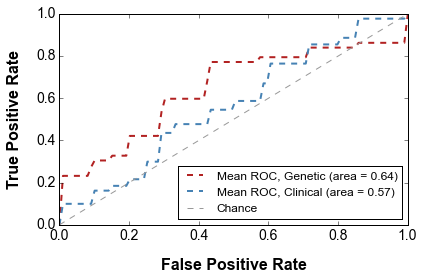

In [180]:
mpl.rc('font',family='Arial')
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(mean_fpr1, mean_tpr1, color='firebrick', ls='--',
         label='Mean ROC, Genetic (area = %0.2f)' % mean_auc1, lw=2)

ax.plot(mean_fpr2, mean_tpr2, color='steelblue', ls='--',
         label='Mean ROC, Clinical (area = %0.2f)' % mean_auc2, lw=2)  


ax.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Chance')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('False Positive Rate', size=16, labelpad=15, weight='bold')
ax.set_ylabel('True Positive Rate', size=16, labelpad=15, weight='bold')
ax.ticklabel_format(size=20)
ax.legend(loc="lower right")

plt.tight_layout()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/rocauc.png',
            format='png', dpi=300, bbox_inches='tight')
plt.show()

In [153]:
def sklearn_prep_total(df):   
    on_columns = ['Patient', 'Visit', 'TMHDS', 'GDS']
    y = np.ravel(df['GDS_Threshold'])
    drop_cols = on_columns + ['GDS_Threshold']
    X = df.drop(drop_cols, axis=1)
    return X, y

Xtot, y = sklearn_prep_total(sklearn_df)
Xtot['Gender'] = Xtot['Gender'].apply(lambda x: int(x == 'Male'))
Xtot['ART'] = Xtot['ART'].apply(lambda x: int(x == 'on'))
Xtot.head()

,Age,Gender,ART,VL,iVL,pVL,CD4,iCD4,nCD4,CD8,...,101L,101K,101M,101F,101P,101S,101T,101W,101Y,101V
0,59,1,1,20,987,987,797,400,400,1131,...,0.000407,0.000000,0,0,0.000081,0.000244,0.000000,0.000163,0,0.00122
1,59,1,1,20,50,470,1167,448,448,663,...,0.000000,0.000757,0,0,0.000000,0.004542,0.000000,0.000000,0,0.00000
2,68,1,1,20,144,39373,771,564,553,958,...,0.002552,0.000000,0,0,0.000150,0.001201,0.000000,0.000000,0,0.00000
3,46,0,1,20,99,164020,1130,398,134,1501,...,0.000000,0.000000,0,0,0.989574,0.000000,0.001813,0.000000,0,0.00000
4,55,1,1,67859,100000,100000,137,36,36,711,...,0.003805,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,0,0.00000


# Single position ranking

1


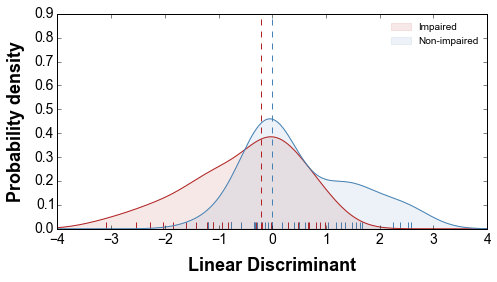

2


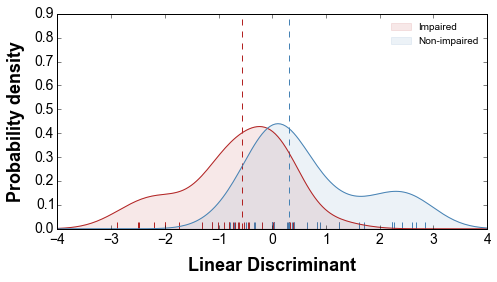

3


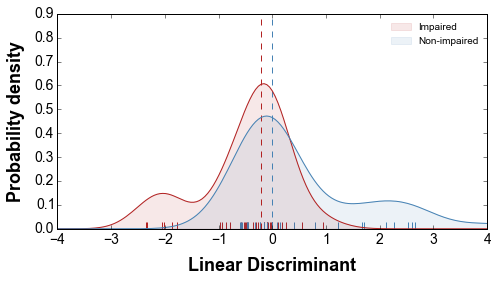

4


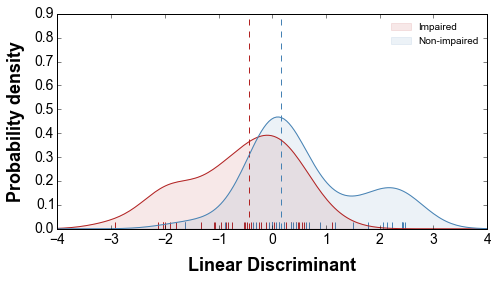

5


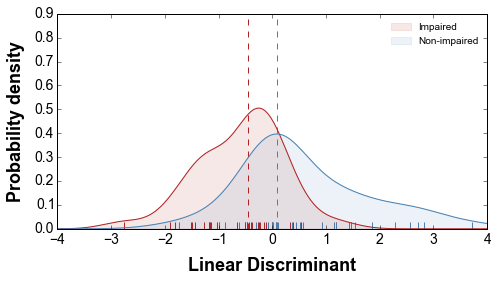

6


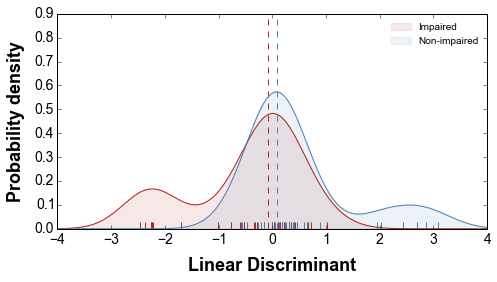

7


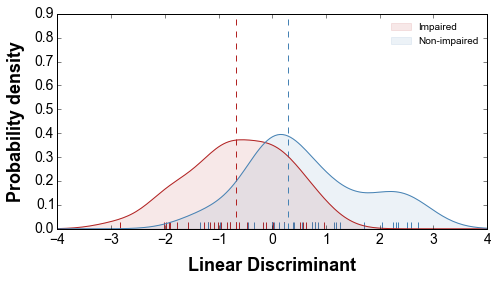

9


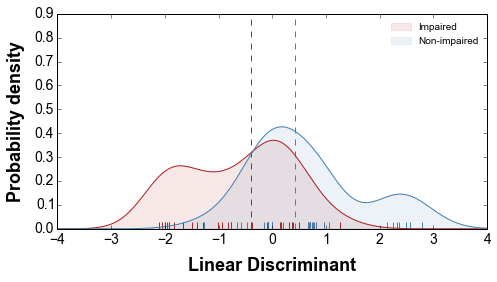

12


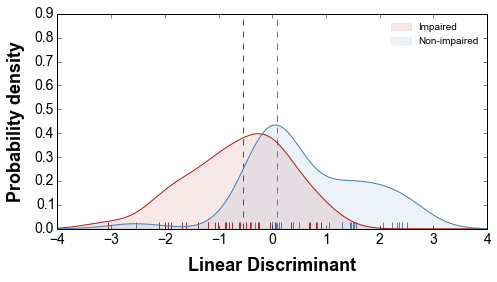

15


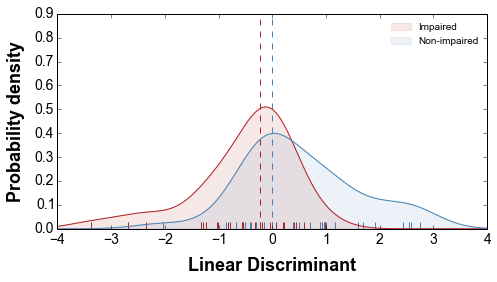

19


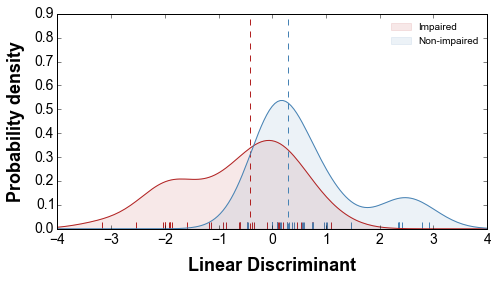

21


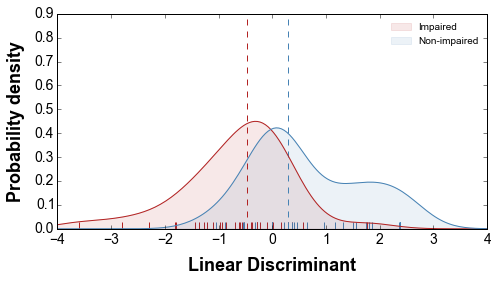

23


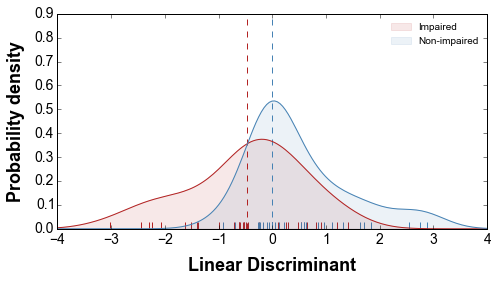

24


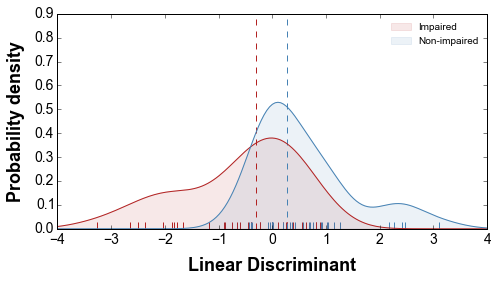

29


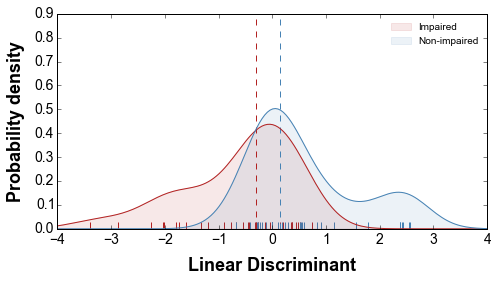

32


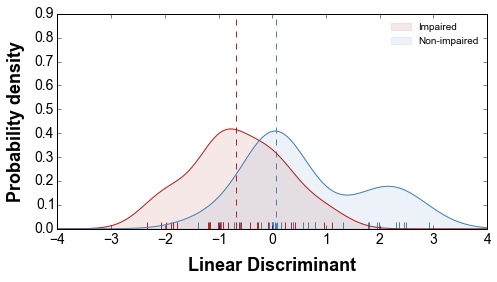

36


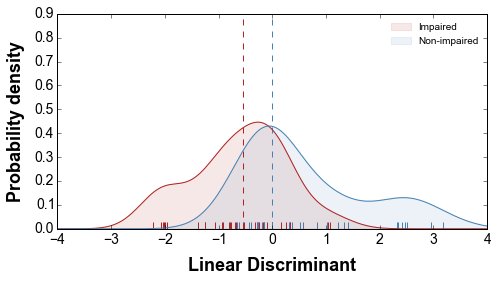

39


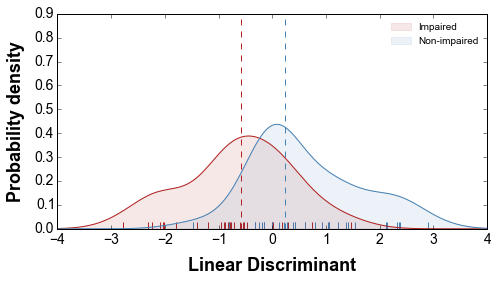

40


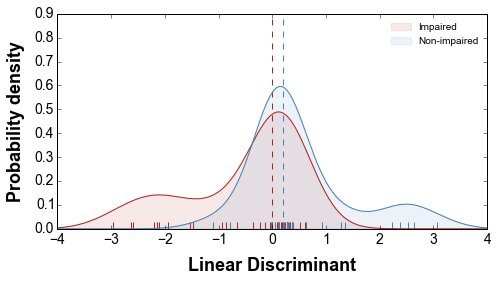

52


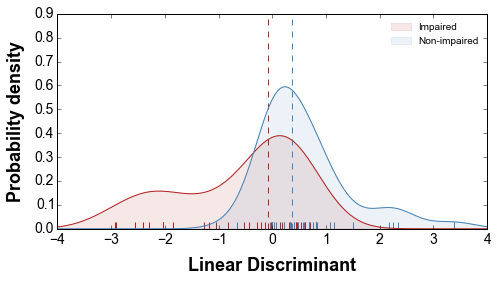

53


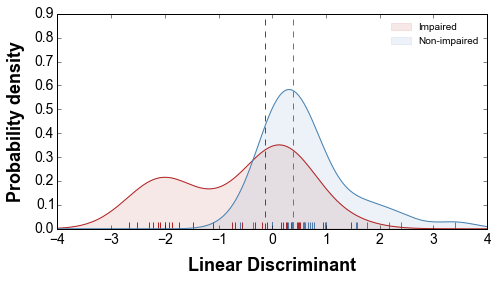

57


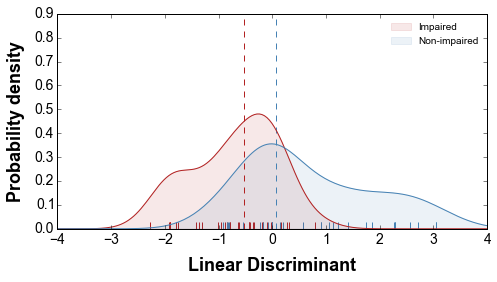

58


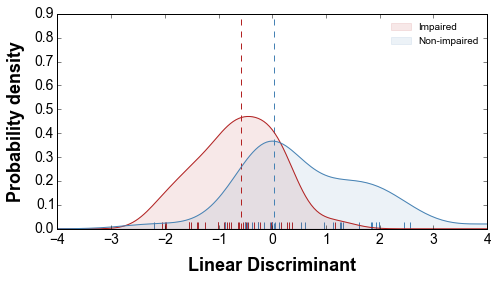

59


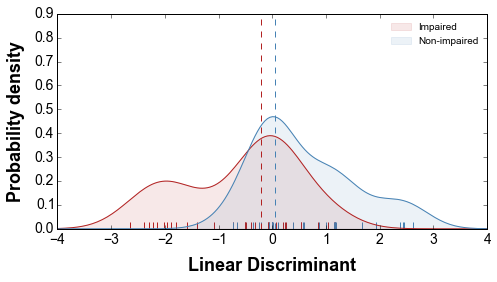

60


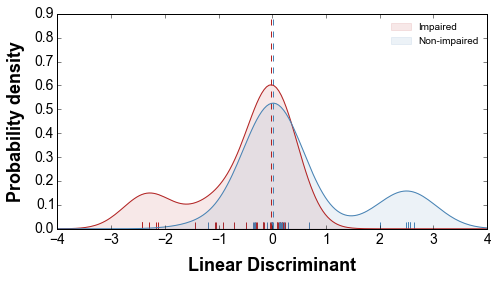

61


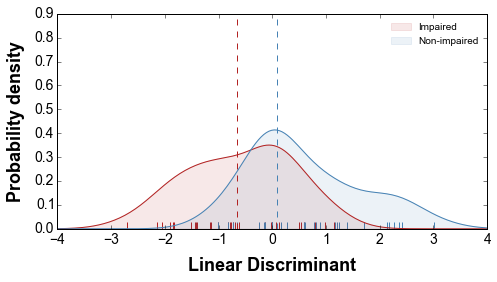

62


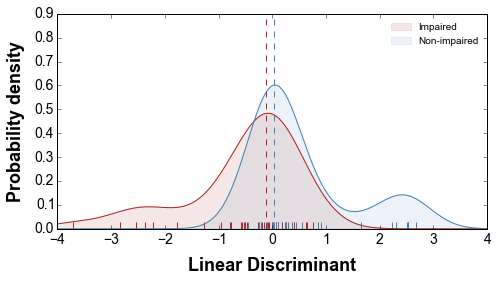

63


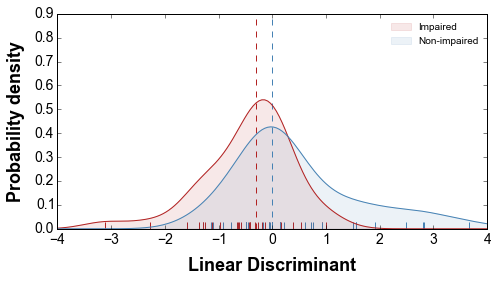

64


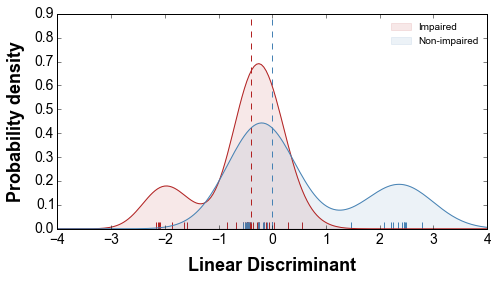

65


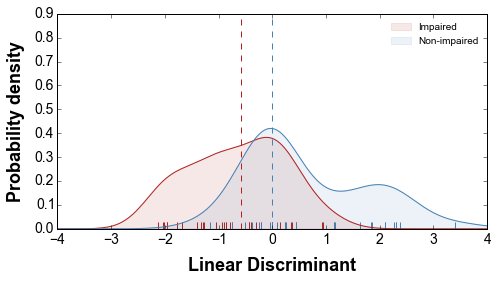

67


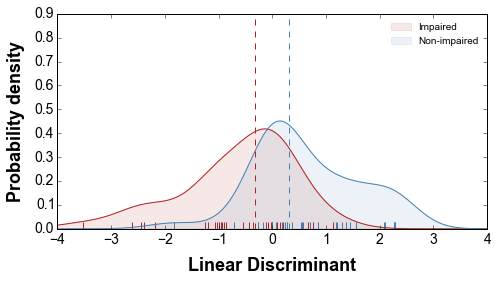

68


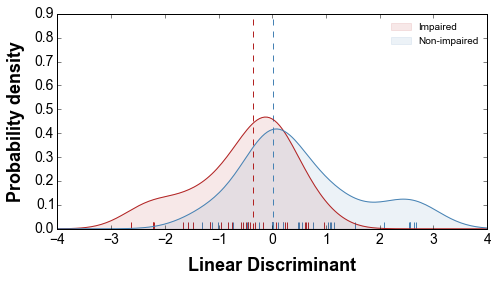

69


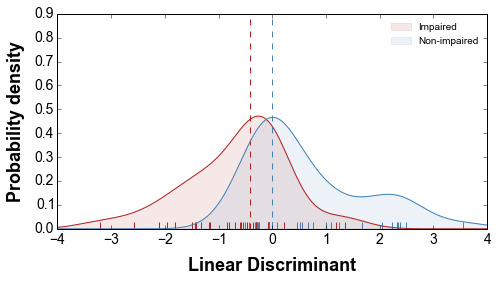

70


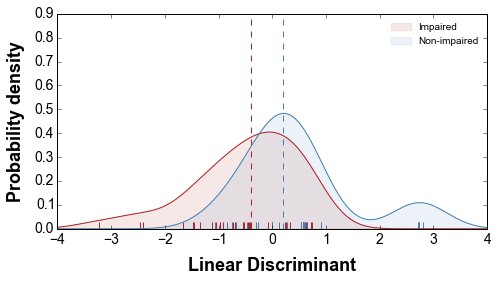

71


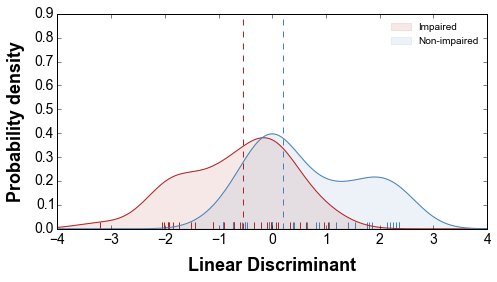

72


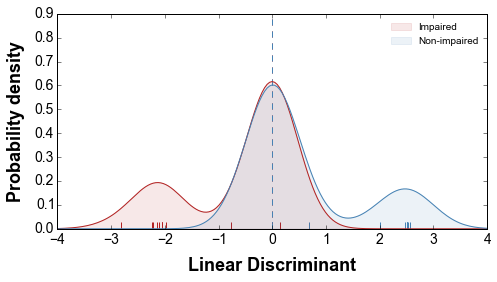

74


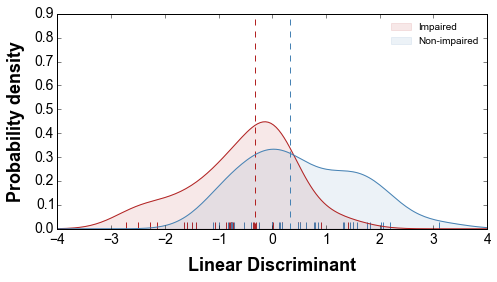

75


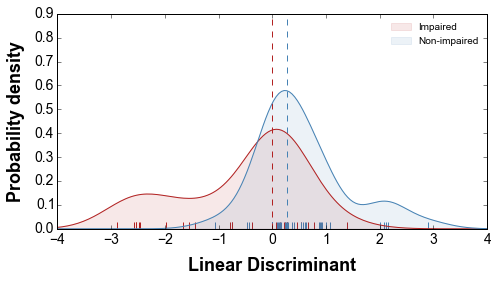

77


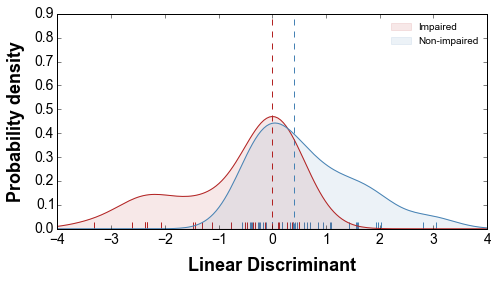

78


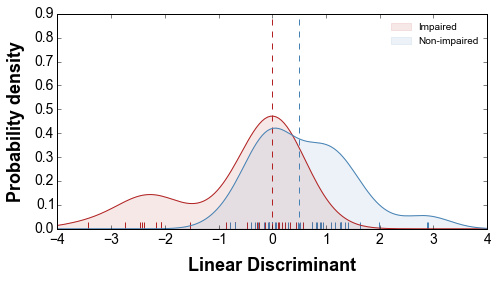

80


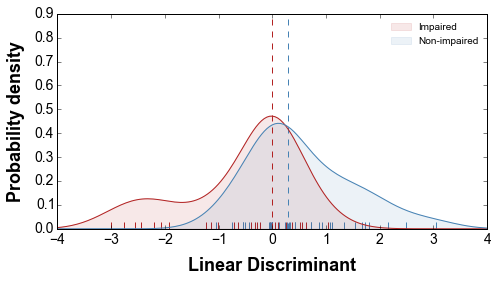

85


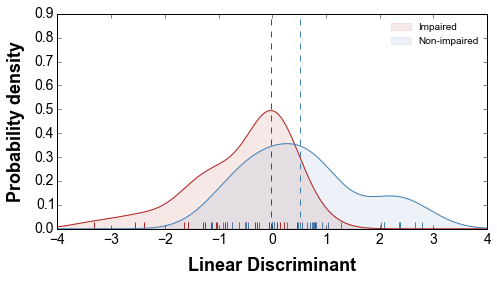

87


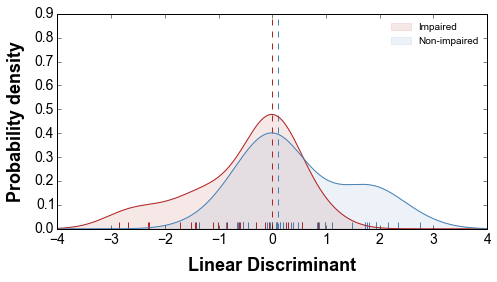

88


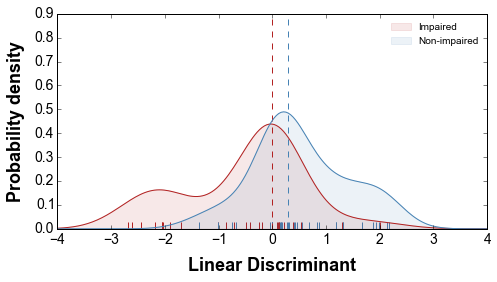

93


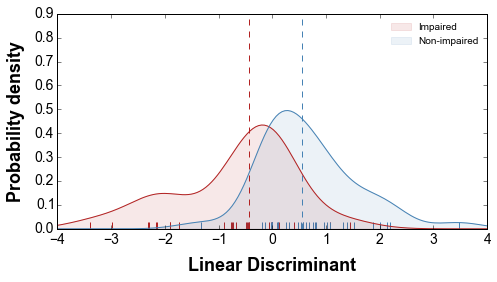

94


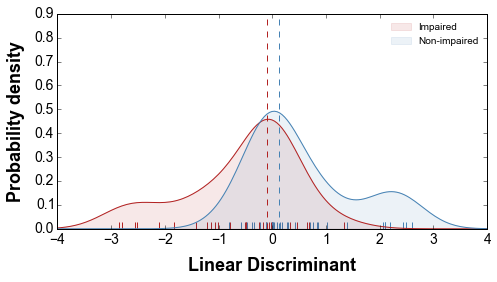

95


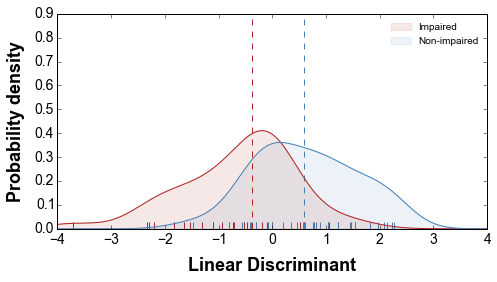

96


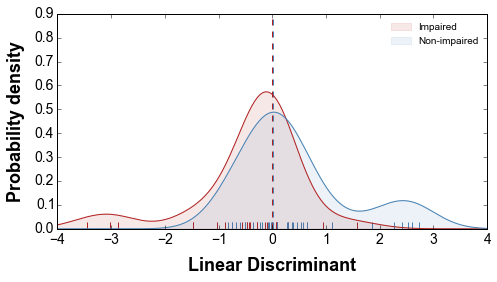

97


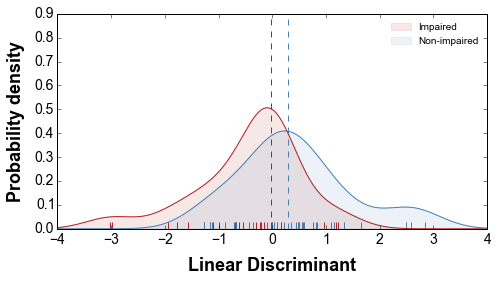

98


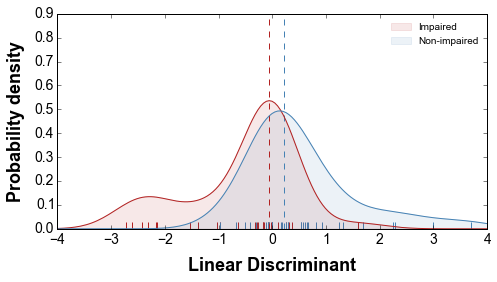

100


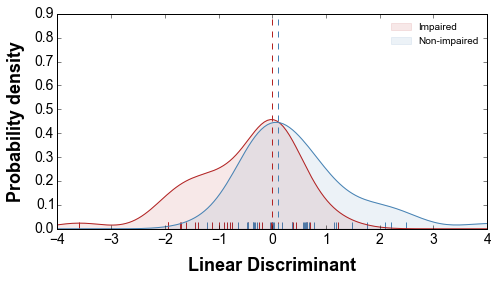

101


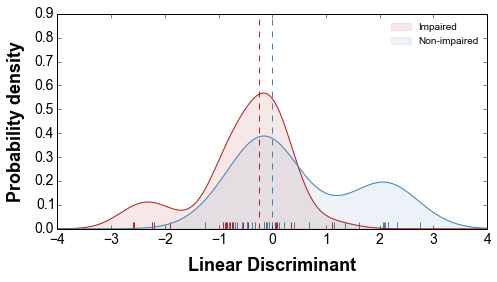

,Hellinger,Position
10,0.484051,19
21,0.481448,57
38,0.472782,77
20,0.466921,53
35,0.465861,72


In [188]:
Xdf,y = sklearn_prep_filter(sklearn_filter_df)

distance_dict = {'Position':[], 'Hellinger':[]}

AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
for i in range(1,102):
    pos_cols = []
    for aa in AAs:
        pos_cols.append(str(i)+aa)
    if pos_cols[0] in list(Xdf.columns):
        X_position = Xdf[pos_cols].as_matrix()
        
        # LDA model
        model = LDA(n_components=2, shrinkage=None)
        X_transform = model.fit(X_position, y).transform(X_position)
        
        x1 = X_transform[y == 0, 0]
        x2 = X_transform[y == 1, 0]
        #coeff, bhatta_dist, hellinger_dist = bhatta(x1,x2,10)
        coeff, hellinger_dist = bhatta_full(x1, x2)
        
        distance_dict['Position'].append(i)
        distance_dict['Hellinger'].append(hellinger_dist)
        
        #if i == 19 or i==101:
        print i
        svpath = '/Users/greg/Desktop/TatFigureStuff/singlepositionLDA/LDA' + str(i) + '.png'
        lda_plot(x1,x2,[-4,4], svpath)
        
distance_df = pd.DataFrame(distance_dict)
distance_df.sort_values(by='Hellinger', inplace=True, ascending=False)
distance_df.head()

In [189]:
distance_df

,Hellinger,Position
10,0.484051,19
21,0.481448,57
38,0.472782,77
20,0.466921,53
35,0.465861,72
1,0.464933,2
34,0.460643,71
28,0.455393,64
19,0.454698,52
14,0.454543,29


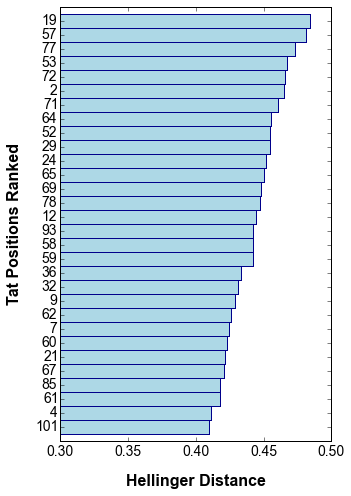

In [179]:
mpl.rc('font',family='Arial')
fig,ax = plt.subplots(figsize=(5,7))

vals = list(distance_df.Hellinger)[0:30]
featurelabels = list(distance_df.Position)[0:30]
pos = np.arange(1,len(vals)+1)[::-1]
ax.barh(pos, vals, height=1, align='center', color='lightblue', edgecolor='darkblue')
ax.tick_params(axis='both', which='major', labelsize=14)

ax.set_ylim([0,len(vals)+1])
ax.set_yticks(pos)
ax.set_yticklabels(featurelabels)

ax.set_xticks(np.arange(0.3,0.55,0.05))
ax.set_xlim([0.3,0.5])

ax.set_ylabel('Tat Positions Ranked', size=16, labelpad=15, weight='bold')
ax.set_xlabel('Hellinger Distance', size=16, labelpad=15, weight='bold')

plt.tight_layout()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/tat_position_rankings.png',
            format='png', dpi=300, bbox_inches='tight')
plt.show()

# Permutations

In [190]:
def shuffle_it(l):
    l2 = l[:].copy()
    random.shuffle(l2)
    return l2 

Xdf,y = sklearn_prep_filter(sklearn_filter_df)
X = Xdf.as_matrix()
selector = VarianceThreshold()
X = selector.fit_transform(X)

model1 = LDA(n_components=2, shrinkage=None)
X_transform = model1.fit(X, y).transform(X)
#print X_transform
x1 = X_transform[y == 0, 0]
x2 = X_transform[y == 1, 0]
coeff, hellinger_dist = bhatta_full(x1,x2)
print hellinger_dist
print ''

random_hellinger = []
for i in range(1000):
    ynew = shuffle_it(y)
    model2 = LDA(n_components=2, shrinkage=None)
    X_transform = model2.fit(X, ynew).transform(X)
    #print X_transform
    x1 = X_transform[ynew == 0, 0]
    x2 = X_transform[ynew == 1, 0]
    coeff, rand_dist = bhatta_full(x1,x2)
    random_hellinger.append(rand_dist)

print np.mean(random_hellinger), np.std(random_hellinger)

x = hellinger_dist
mu = np.mean(random_hellinger)
sigma = np.std(random_hellinger)
z = (x - mu)/ sigma
print z

0.661174569735

0.656095094605 0.0552884472615
0.091872269552


# Differences

In [196]:
AAs = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
Xdf = sklearn_filter_df

for i in range(1,102):
    pos_cols = []
    for aa in AAs:
        pos_cols.append(str(i)+aa)
    if pos_cols[0] in list(Xdf.columns):
        print Xdf[pos_cols]
        #X_position = Xdf[pos_cols].as_matrix()

          1A        1R        1N        1D        1C        1Q        1E  \
0   0.000051  0.002157  0.000051  0.000077  0.002080  0.000051  0.000308   
1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2   0.000000  0.001661  0.000000  0.000000  0.000000  0.000000  0.001661   
3   0.000000  0.001347  0.000673  0.000000  0.000673  0.000000  0.000000   
4   0.000000  0.002994  0.000000  0.000000  0.000000  0.000000  0.000000   
5   0.000126  0.002142  0.000000  0.000000  0.001638  0.000000  0.000378   
6   0.000000  0.001695  0.000000  0.000000  0.000000  0.000000  0.000000   
7   0.000000  0.002363  0.000000  0.000000  0.002953  0.000000  0.000000   
8   0.000000  0.001865  0.000070  0.000000  0.001724  0.000070  0.000035   
9   0.000000  0.002118  0.000163  0.000000  0.002118  0.000000  0.000000   
10  0.000000  0.002247  0.000000  0.000000  0.000000  0.000000  0.000000   
11  0.000032  0.002334  0.000095  0.000032  0.002303  0.000063  0.000032   
12  0.000000